# Find the flag!

Can you guess which continent this flag comes from?  
![flag](Images/reunion.webp)  
What are some of the features that would clue you in? Maybe some of the colors are good indicators. The presence or absence of certain shapes could give you a hint. In this project, we’ll use decision trees to try to predict the continent of flags based on several of these features.

We’ll explore which features are the best to use and the best way to create your decision tree.

## Datasets

The original data set is available at the UCI Machine Learning Repository:
- [https://archive.ics.uci.edu/ml/datasets/Flags](https://archive.ics.uci.edu/dataset/40/flags)

In [255]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [256]:
cols = ['name','landmass','zone', 'area', 'population', 'language','religion','bars','stripes','colours', 
        'red','green','blue','gold','white','black','orange','mainhue','circles', 
        'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate','text','topleft','botright']

df= pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data", names = cols)

var = ['red', 'green', 'blue','gold', 'white', 'black', 'orange', 'mainhue','bars','stripes', 'circles','crosses', 
       'saltires','quarters','sunstars','triangle','animate']

In [257]:
len(var)

17

##  1.

- he dataset has been loaded for you and saved as a dataframe named `df`. 
- Some of the input and output features of interest are:
    - `name`: Name of the country concerned
    - `landmass`: 1=N.America, 2=S.America, 3=Europe, 4=Africa, 5=Asia, 6=Oceania
    - `bars`: Number of vertical bars in the flag
    - `stripes`: Number of horizontal stripes in the flag
    - `colours`: Number of different colours in the flag
    - `red`: 0 if red absent, 1 if red present in the flag
    - …
    - `mainhue`: predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue)
    - `circles`: Number of circles in the flag
    - `crosses`: Number of (upright) crosses
    - `saltires`: Number of diagonal crosses
    - `quarters`: Number of quartered sections
    - `sunstars`: Number of sun or star symbols
- We will build a decision tree classifier to predict what continent a particular flag comes from. 
- Before that, we want to understand the distribution of flags by continent. 
- Calcluate the count of flags by `landmass` value.

In [258]:
df.landmass.value_counts().reset_index().replace({1: 'North America', 2: 'South America', 3: 'Europe', 4: 'Africa', 5: 'Asia', 6: 'Oceania'})

,landmass,count
0,Africa,52
1,Asia,39
2,Europe,35
3,North America,31
4,Oceania,20
5,South America,17


##  2.

- Rather than looking at all six continents, we will focus on just two, Europe and Oceania. 
- Create a new dataframe with only flags from Europe and Oceania.

In [259]:
df_eur_oce = df[df['landmass'].isin([3, 6])]
df_eur_oce.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
10,Australia,6,2,7690,15,1,1,0,0,3,...,1,1,6,0,0,0,0,0,white,blue
11,Austria,3,1,84,8,4,0,0,3,2,...,0,0,0,0,0,0,0,0,red,red


##  3.

- Given the list of predictors in the list `var`, print the average values of each for these two continents. 
- Note which predictors have very different averages.

In [260]:
df_eur_oce.groupby('landmass')[var].mean(numeric_only=True)

,red,green,blue,gold,white,black,orange,bars,stripes,circles,crosses,saltires,quarters,sunstars,triangle,animate
landmass,,,,,,,,,,,,,,,,
3,0.828571,0.2,0.514286,0.428571,0.771429,0.171429,0.057143,0.628571,1.285714,0.028571,0.285714,0.028571,0.028571,0.142857,0.028571,0.114286
6,0.800000,0.2,0.800000,0.600000,0.950000,0.150000,0.150000,0.000000,0.400000,0.150000,0.400000,0.300000,0.400000,3.300000,0.250000,0.300000


##  4.

- We will build a classifier to distinguish flags for these two continents – but first, inspect the variable types for each of the predictors.
    ```python	
    labels = (df["landmass"].isin([3,6]))*1
    ```	

In [261]:
labels = (df["landmass"].isin([3,6]))*1
df_eur_oce[var].dtypes

red          int64
green        int64
blue         int64
gold         int64
white        int64
black        int64
orange       int64
mainhue     object
bars         int64
stripes      int64
circles      int64
crosses      int64
saltires     int64
quarters     int64
sunstars     int64
triangle     int64
animate      int64
dtype: object

##  5.

- Note that all the predictor variables are numeric except for `mainhue`. 
- Transform the dataset of predictor variables to dummy variables and save this in a new dataframe called `data`.

In [262]:
data = pd.get_dummies(df[var], columns=['mainhue']).reset_index(drop=True)
data.head()

,red,green,blue,gold,white,black,orange,bars,stripes,circles,...,triangle,animate,mainhue_black,mainhue_blue,mainhue_brown,mainhue_gold,mainhue_green,mainhue_orange,mainhue_red,mainhue_white
0,1,1,0,1,1,1,0,0,3,0,...,0,0,False,False,False,False,True,False,False,False
1,1,0,0,1,0,1,0,0,0,0,...,0,1,False,False,False,False,False,False,True,False
2,1,1,0,0,1,0,0,2,0,0,...,0,0,False,False,False,False,True,False,False,False
3,1,0,1,1,1,0,1,0,0,0,...,1,1,False,True,False,False,False,False,False,False
4,1,0,1,1,0,0,0,3,0,0,...,0,0,False,False,False,True,False,False,False,False


##  6.

- Split the data into a train and test set.

In [263]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4, random_state=42)

##  7.

- We will explore tuning the decision tree model by testing the performance over a range of `max_depth` values. 
- Fit a decision tree classifier for `max_depth` values from 1-20. 
- Save the accuracy score in for each depth in the list `acc_depth`.

In [264]:
acc_depth = []
depths = range(1, 21)
for i in depths:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    acc_depth.append(clf.score(X_test, y_test))

##  8.

- Plot the accuracy of the decision tree models versus the `max_depth`.

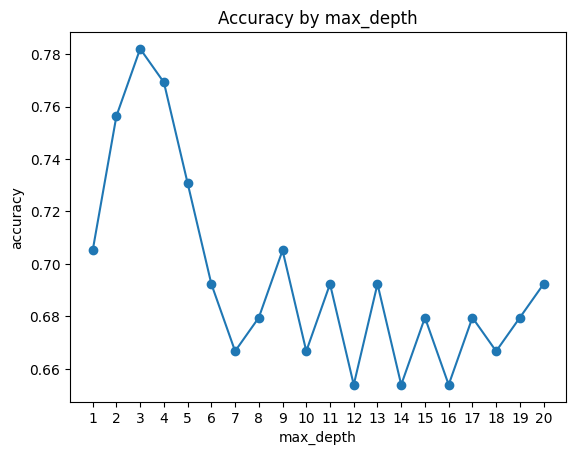

In [265]:
plt.plot(depths, acc_depth, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Accuracy by max_depth')
ax = plt.gca()
ax.set_xticks(depths)
plt.show()

##  9.

- Find the largest accuracy and the depth this occurs.

In [266]:
max_acc = max(acc_depth)
max_depth = acc_depth.index(max_acc) + 1

max_acc, max_depth

(0.782051282051282, 3)

##  10.

- Refit the decision tree model using the `max_depth` from above; plot the decision tree.

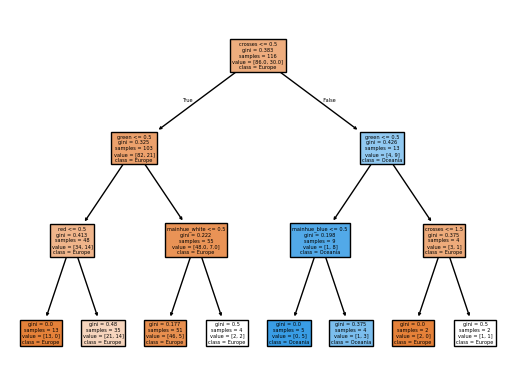

In [267]:
dtree = DecisionTreeClassifier(max_depth=max_depth)
dtree.fit(X_train, y_train)

tree.plot_tree(dtree, feature_names=data.columns, class_names=['Europe', 'Oceania'], filled=True)
plt.show()

##  11.

- Like we did with `max_depth`, we will now tune the tree by using the hyperparameter `ccp_alpha`, which is a pruning parameter. 
- Fit a decision tree classifier for each value in `ccp`. 
- Save the accuracy score in the list `acc_pruned`.

In [268]:
ccps = np.arange(0, 0.05, 0.005)
acc_ccp = []
for ccp in ccps:
    clf = DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=ccp)
    clf.fit(X_train, y_train)
    acc_ccp.append(clf.score(X_test, y_test))

##  12.

- Plot the accuracy of the decision tree models versus the `ccp_alpha`.

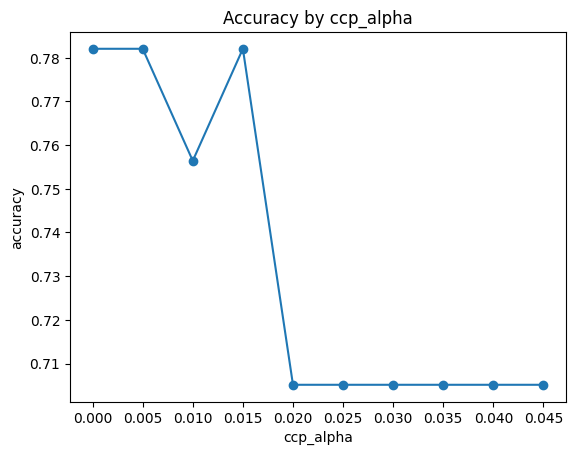

In [269]:
plt.plot(ccps, acc_ccp, marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('accuracy')
plt.title('Accuracy by ccp_alpha')
ax = plt.gca()
ax.set_xticks(ccps)
plt.show()

##  13.

- Find the largest accuracy and the `ccp_alpha` value this occurs.

In [270]:
max_acc_ccp = max(acc_ccp)
max_ccp = acc_ccp.index(max_acc_ccp) + 1

max_acc_ccp, max_ccp, ccps[max_ccp]

(0.782051282051282, 1, np.float64(0.005))

##  14.

- Fit a decision tree model with the values for `max_depth` and `ccp_alpha` found above. 
- Plot the final decision tree.

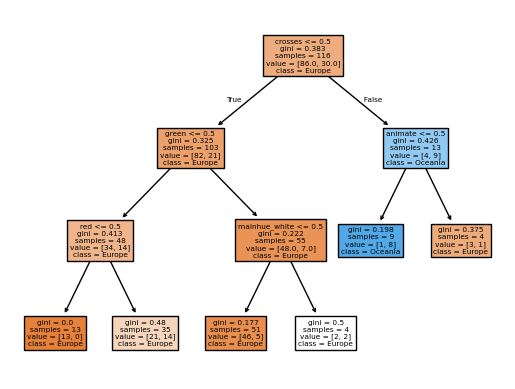

In [271]:
dtree = DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=ccps[max_ccp])
dtree.fit(X_train, y_train)

tree.plot_tree(dtree, feature_names=data.columns, class_names=['Europe', 'Oceania'], filled=True)
plt.show()

##  15.

- Note that the accuracy of our final model increased and the structure of the tree was simpler – many unnecessary branches were removed in the pruning process making for a much easier interpretation.
- There are a few different ways to extend this project:
    - Try to classify something else! Rather than predicting the `"Landmass"` feature, could predict something like the `"Language"`?
    - Find a subset of features that work better than what we’re currently using. An important note is that a feature that has categorical data won’t work very well as a feature. For example, we don’t want a decision node to split nodes based on whether the value for `"Language"` is above or below `5`.
    - Tune more parameters of the model. You can find a description of all the parameters you can tune in the [Decision Tree Classifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). For example, see what happens if you tune max_leaf_nodes. Think about whether you would be overfitting or underfitting the data based on how many leaf nodes you allow.